## Test WCS for corner sensors

Aim: solve the problem why when providing a set of x,y pixels, I see an offset in PhoSim images of where they are supposed to be.
   
minimal code from `baseAOSLoop.py`
        
        
        xPx = [200,500,1000]
        yPx = [1000,2000,3000]
        # skySim= self._prepareSkySimByChipPos(sensorNameList,raInDeg,
        #     decInDeg,rotAngInDeg,
        #     starMag,xPx=xPx,yPx=yPx)
        skySim = SkySim()

        skySim.setObservationMetaData(raInDeg, decInDeg, rotSkyPos, mjd)

        starId = 0 
        for sensor in sensorName:
            for i in range(len(xPx)):
                skySim.addStarByChipPos(sensor, starId, xPx[i],
                                        yPx[i], starMag)
                starId += 1 


The stars were simulated with the following one-liner that can be copy-pasted to the terminal : 

In [3]:
import os
import argparse
import numpy as np

from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18
%matplotlib inline
import matplotlib.pyplot as plt 
plt.style.use('dark_background')

import sys
sys.path.append('../analysis_tools/')
import analysisTools as at

topDir = '/astro/store/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_wfs'
outputDir = os.path.join(topDir,'baselineTest_2020_24_noBkgnd_noContam')

cmd = 'python baseAOSLoop.py'
numPro = 20
iterNum = 5
opdCmdSettingsFile = 'opdDefault.cmd'
# I use that to match the beginning of the star cmd file below.
# this opdDefault.cmd has : 
# 
#         backgroundmode 0
#         raydensity 0.0
#         perturbationmode 1

starCmdSettingsFile = 'starDefault.cmd'
# starDefault.cmd   has  : 
# 
#         backgroundmode 0
#         raydensity 0.0
#         perturbationmode 1
#
#         trackingmode 0
#         cleartracking
#         clearclouds
#         lascatprob 0.0
#         contaminationmode 0  <-- no contam  ! 
#         diffractionmode 1
#         straylight 0
#         detectormode 0
#         centroidfile 1

selectSensors = 'lsstcam'
#skyFilePath = os.path.join(topDir, 'skyWfsArrow.txt')

args = '--numPro %d --iterNum %d --outputDir %s \
 --opdCmdSettingsFile %s --starCmdSettingsFile %s \
--selectSensors %s --clobber --dbFileName bsc0.db3 '%(numPro, iterNum, outputDir,
            opdCmdSettingsFile, starCmdSettingsFile, selectSensors)
print('\n Run in terminal:')
print('%s %s'%(cmd,args))


 Run in terminal:
python baseAOSLoop.py --numPro 20 --iterNum 5 --outputDir /astro/store/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_wfs/baselineTest_2020_24_noBkgnd_noContam  --opdCmdSettingsFile opdDefault.cmd --starCmdSettingsFile starDefault.cmd --selectSensors lsstcam --clobber --dbFileName bsc0.db3 


The result is  

data_id is
{'visit': 9006002, 'filter': 'g', 'raftName': 'R00', 'detectorName': 'S22', 'detector': 197}
Reading postISR images from the following repo_dir:
/astro/store/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_wfs/baselineTest_2020_24_noBkgnd_noContam/input/rerun/run1
Done



Text(0.5, 1.0, 'catalog x,y and the postISR image')

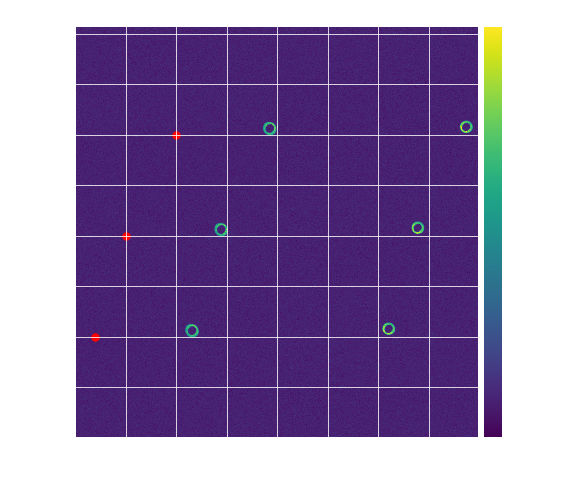

In [24]:
image = at.readImage(outputDir,raft='R00',detector='S22', focalType='intra')
%matplotlib inline
fig,ax = plt.subplots(1,1,figsize=(8,8))
at.plotImage(image, ax,plotArgs={'vmax':400})
ax.grid()
xPx = [200,500,1000]
yPx = [1000,2000,3000]
ax.scatter(xPx,yPx,s=55,c='r')
ax.set_title('catalog x,y and the postISR image')

So there is an offset between where the donuts are, and where I would expect them to be (red dots).

Investigating the following steps : 

# 1) SkySim: do we get back what we put in ? (x,y <==> ra,dec) 

SkySim uses `lsst.sims.coordUtils.CameraUtils.raDecFromPixelCoords` to get  ra,dec from x,y  .  If we're using `WcsSol.py`, then it uses the converse function `lsst.sims.coordUtils.CameraUtils.pixelCoordsFromRaDec` to get x,y from ra,dec. Check that we recover the input coordinates: 

In [25]:
from astropy.time import Time

In [26]:
t = Time('2000-01-01T00:00:00', format='isot', scale='utc')

In [29]:
t.mjd

51544.0

In [30]:
from lsst.sims.utils import ObservationMetaData

from lsst.sims.coordUtils.CameraUtils import raDecFromPixelCoords
from lsst.sims.coordUtils.CameraUtils import pixelCoordsFromRaDec

from lsst.sims.coordUtils import raDecFromPixelCoordsLSST
from lsst.sims.coordUtils import pixelCoordsFromRaDecLSST

from lsst.obs.lsstSim import LsstSimMapper
from lsst.ts.wep.SourceProcessor import SourceProcessor
from lsst.ts.wep.Utility import expandDetectorName

_sourProc = SourceProcessor()
sensorName = 'R00_S22_C1'
_sourProc.config(sensorName=sensorName)

xInpixelInCam = 200
yInPixelInCam = 1000
print('Cam X,Y: ', xInpixelInCam, yInPixelInCam)
pixelDmX, pixelDmY = _sourProc.camXY2DmXY(xInpixelInCam,
                                          yInPixelInCam)


print('DM X,Y: ', pixelDmX, pixelDmY)
# Expand the sensor name
expandedSensorName = expandDetectorName(sensorName)

# this doesn't change if I set mjd = 51544 which corresponds to the year 2000.0,
# which is the default epoch
t = Time('2000-01-01T00:00:00', format='isot', scale='utc')
mjd = t.mjd
_obs = ObservationMetaData(pointingRA=0, pointingDec=0,
                           rotSkyPos=0, mjd=mjd)
includeDistortion = True

raInDeg, declInDeg = raDecFromPixelCoords(
    pixelDmX, pixelDmY, expandedSensorName, camera=LsstSimMapper().camera,
    obs_metadata=_obs, epoch=2000,
    includeDistortion=includeDistortion)

# # that's an alternative function but it doesn't make a difference ... 
raInDeg_1, declInDeg_1 = raDecFromPixelCoordsLSST(
    pixelDmX, pixelDmY, expandedSensorName,
    obs_metadata=_obs, epoch=2000,
    includeDistortion=includeDistortion)

# if we use WcsSol.py, it's using https://github.com/lsst-ts/ts_wep/blob/uw_dev/python/lsst/ts/wep/bsc/WcsSol.py 
#from lsst.sims.coordUtils.CameraUtils import pixelCoordsFromRaDec

xOut, yOut = pixelCoordsFromRaDec(raInDeg, declInDeg, obs_metadata=_obs,
                                    chipName=expandedSensorName, camera=LsstSimMapper().camera,
                                    epoch=2000.0,
                                    includeDistortion=includeDistortion)

xOut1, yOut1 = pixelCoordsFromRaDecLSST(raInDeg_1, declInDeg_1, obs_metadata=_obs,
                                    chipName=expandedSensorName,
                                    epoch=2000.0,
                                    includeDistortion=includeDistortion)


print('Using lsst.sims.coordUtils.CameraUtils.raDecFromPixelCoords, .pixelCoordsFromRaDec',  xOut,yOut)
print('Using lsst.sims.coordUtils.raDecFromPixelCoordsLSST, .pixelCoordsFromRaDecLSST', xOut1, yOut1)

Cam X,Y:  200 1000
DM X,Y:  1000 1800
Using lsst.sims.coordUtils.CameraUtils.raDecFromPixelCoords, .pixelCoordsFromRaDec 999.9999999910494 1799.9999991912016
Using lsst.sims.coordUtils.raDecFromPixelCoordsLSST, .pixelCoordsFromRaDecLSST 1000.0000016934724 1799.999997676954


So it's quite close. `IncludeDistortion = True`  improves things by few pixels on each end, it is on by default. 

# 2) Given the PhoSim WCS  and catalog ra,dec --> x,y

In [15]:
import lsst.daf.persistence as dafPersist

topDir = '/astro/store/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_wfs'
outputDir = os.path.join(topDir,'baselineTest_2020_24_noBkgnd_noContam')
data_dir = outputDir

focalType = 'intra'
raft = 'R00'
detector = 'S22'
rerun='run1'
# if Butler args are no provided, attempting to 
# guess based on the following:

sensor = raft+'_'+detector 


# this applies to ComCam ...
detNumDict = {'R22_S00':90, 'R22_S01':91, 'R22_S02':92,   # ComCam detector ids 
              'R22_S10':93, 'R22_S11':94, 'R22_S12':95, 
              'R22_S20':96, 'R22_S21':97, 'R22_S22':98,
              'R00_S22':197,'R04_S20':204,    # WFS detector ids 
              'R40_S02':209, 'R44_S00':216
              }

detNum = detNumDict[sensor]    
# these are decided in baseComcamLoop.py or baseWfsLoop.py 
obsIdDic = {'focal':9006000, 'extra':9006001,  'intra':9006002}

#if not obsId: # if not provided, reading it from a dict, based on the focal type
obsId = obsIdDic[focalType]

# assemble data_id arguments for Butler 
data_id = {'visit': obsId, 'filter': 'g', 'raftName': raft, 
           'detectorName': detector, 'detector': detNum
          }

print('data_id is')
print(data_id)
# Read each figure as a postage stamp, store data to an array 

repo_dir = os.path.join(data_dir, 'input/rerun/', rerun)
print('Reading postISR images from the following repo_dir:')
print(repo_dir)

butler = dafPersist.Butler(repo_dir)

# show what keys are needed by the `postISRCCD` data type.... 
# butler.getKeys('postISRCCD')
# yields {'visit': int, 'filter': str,'raftName': str, 'detectorName': str, 'detector': int}
post = butler.get('postISRCCD', **data_id) 



data_id is
{'visit': 9006002, 'filter': 'g', 'raftName': 'R00', 'detectorName': 'S22', 'detector': 197}
Reading postISR images from the following repo_dir:
/astro/store/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_wfs/baselineTest_2020_24_noBkgnd_noContam/input/rerun/run1


Given the WCS from the postISR CCD and the input catalog (ra,dec), we use the WCS to get (x,y):

In [16]:
image = post.image.array
wcs = post.getWcs()

from astropy.table import Table
cat_dir = data_dir
cat_path = os.path.join(cat_dir,'iter0/pert/',  'skyInfo.txt' )
cat = Table.read(cat_path, format='ascii')


# This function was pointed out to me by Eli Rykoff 
# https://github.com/LSSTDESC/supreme/blob/75a2008d203e28b3d42738374823f1f5e42d9db1/supreme/utils.py#L181
# and sparked this ticket https://jira.lsstcorp.org/browse/DM-26485
def radec_to_xy(wcs, ra, dec):
    """
    Convert ra/dec arrays to xy array
    Parameters
    ----------
    wcs : `lsst.afw.geom.SkyWcs`
       WCS object
    ra : `numpy.ndarray`
       Float array of RA positions
    dec : `numpy.ndarray`
       Float array of Dec positions
    Returns
    -------
    xy : `numpy.ndarray`
       2xN array of x/y positions associated with input ra/dec
    """
    xy = wcs.getTransform().getMapping().applyInverse(np.deg2rad(np.vstack((ra, dec))))
    return xy.T


xy = radec_to_xy(wcs, cat['Ra'].data, cat['Decl'].data)

Text(0.5, 1.0, 'catalog ra,dec --> x,y given PhoSim WCS')

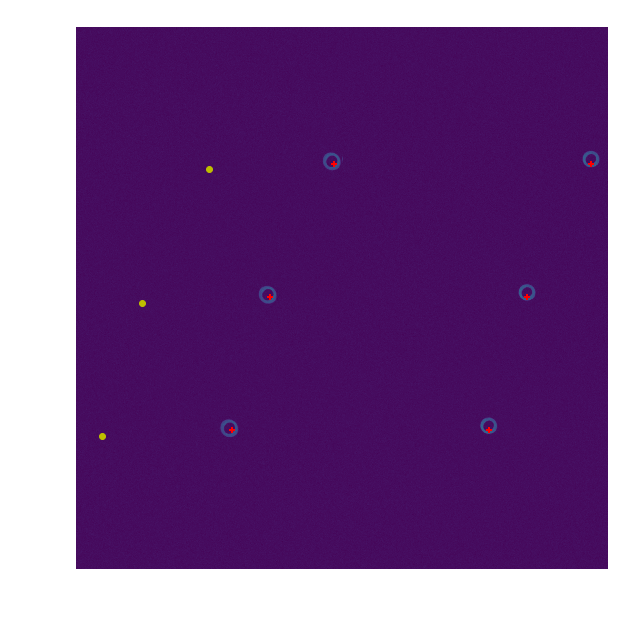

In [23]:

xs = xy[:,0]
ys = xy[:,1]

fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(image.T, origin='lower', vmax=1200)
ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')
mx = (0 < xs)*(xs<4000)
my = (0 < ys)*(ys<4000)
mxy = mx*my
args = {'marker':'+', 's':40,'edgecolor':'red', 
         'facecolor':'red', 'linewidth':2}
ax.scatter(ys[mxy],xs[mxy],**args)

xPx = [200,500,1000]
yPx = [1000,2000,3000]
ax.scatter(xPx,yPx, c='y')    
ax.set_title('catalog ra,dec --> x,y given PhoSim WCS')


yellow dots show where we would expect the points to be based on the input. The red crosses show the location of the points given the catalog ra,dec and the PhoSim WCS   

# 3) MJD matters in where SourceSelector thinks that sensors are located (if using WcsSol)

This is because `SourceSelector.py`  in `sourSelc.getTargetStarByFile()`  when it asks for `neighborStarMap, starMap, wavefrontSensors = self.getTargetStar(offset=offset)`, the following is called  inside `getTargetStar` : 

     wavefrontSensors = self.camera.getWavefrontSensor()
    lowMagnitude, highMagnitude = self.filter.getMagBoundary()

    # Query the star database
    starMap = dict()
    neighborStarMap = dict()
    for detector, wavefrontSensor in wavefrontSensors.items():

    # Get stars in this wavefront sensor for this observation field
    stars = self.db.query(mappedFilterType, wavefrontSensor[0],
                          wavefrontSensor[1], wavefrontSensor[2],
                          wavefrontSensor[3])

i.e. the boundary of the sensors is taken from `sourSelc.camera.getWavefrontSensor()` : 

In [32]:
# minimal example 
from lsst.ts.wep.Utility import CamType
from lsst.ts.wep.ctrlIntf.WEPCalculationFactory import WEPCalculationFactory

wep_calc = WEPCalculationFactory.getCalculator(CamType.LsstCam, outputDir)
sourSelc = wep_calc.wepCntlr.getSourSelc()



Using mjd=50000, c=r
R:0,0 S:2,2,A
R:0,4 S:2,0,A
R:4,0 S:0,2,A
R:4,4 S:0,0,A
R:0,0 S:2,2,B
R:0,4 S:2,0,B
R:4,0 S:0,2,B
R:4,4 S:0,0,B

Using mjd=59000, c=g
R:0,0 S:2,2,A
R:0,4 S:2,0,A
R:4,0 S:0,2,A
R:4,4 S:0,0,A
R:0,0 S:2,2,B
R:0,4 S:2,0,B
R:4,0 S:0,2,B
R:4,4 S:0,0,B


Text(0.5, 1.0, 'Difference in sensor boundaries \nbetween mjd=50000 (red) and 59000 (green)')

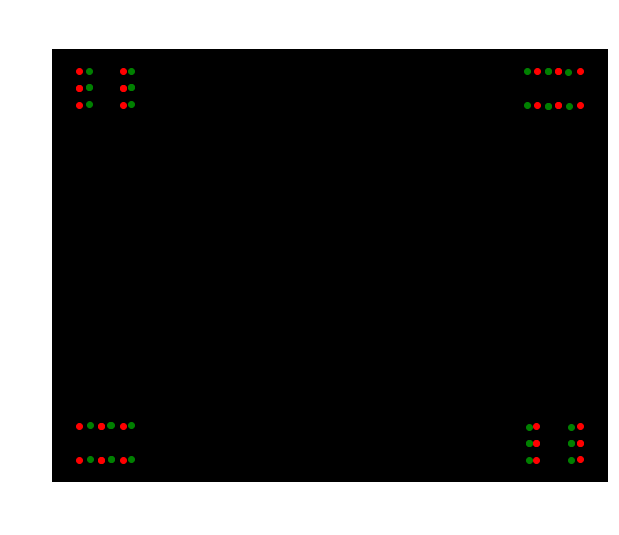

In [46]:
%matplotlib inline

fig,ax = plt.subplots(1,1,figsize=(10,8))
#thes coords are center of each sensor 
raInDeg = 0 ; decInDeg = 0 ; rotSkyPos = 0 
mjds=[50000, 59000,]
for mjd,c in zip(mjds,['r','g', 'y']):
    
    print('\nUsing mjd=%d, c=%s'%(mjd,c))
    # set the MJD explicitly in camera 
    sourSelc.camera.setObsMetaData(raInDeg,decInDeg,rotSkyPos, mjd)
    
    wavefrontSensors= sourSelc.camera.getWavefrontSensor()
    for detector, wavefrontSensor in wavefrontSensors.items():
        print(detector)#, wavefrontSensor)  

        corner1 = wavefrontSensor[0]
        corner2 = wavefrontSensor[1]
        corner3 = wavefrontSensor[2]
        corner4 = wavefrontSensor[3]
        ra = np.array([corner1[0], corner2[0], corner3[0], corner4[0]])
        decl = np.array([corner1[1], corner2[1], corner3[1], corner4[1]])

        # switch from (0,360) to (-180,180) 
        # just for plotting 
        m = ra>180
        ra[m] = ra[m] - 360
        #print(ra)
        #print(decl)
        ax.scatter(ra,decl,c=c, label=mjd)
    ax.set_xlabel('Ra [deg]')
    ax.set_xlabel('Decl [deg]')
    ax.grid()
#ax.legend()
ax.set_title('Difference in sensor boundaries \nbetween mjd=%d (red) and %d (green)'%(mjds[0],mjds[1]))

The detector corners in x,y are taken from https://github.com/lsst-ts/ts_wep/blob/844af07444ee7e9d0ae7a1a8b4f97b084819f15e/python/lsst/ts/wep/bsc/CameraData.py#L108 
    
Then the `getWavefrontSensor` method calls `_getDetectorRaDec` for the list of wavefront sensor names , which uses 
    
     ra_dec_out = dict()
    for detector in detectorList:

        coords = self._corners[detector]
        xPix = coords[0]
        yPix = coords[1]

        chipName = np.array([detector] * len(xPix))
        ra, dec = self._wcs.raDecFromPixelCoords(
            xPix, yPix, chipName, epoch=2000.0, includeDistortion=True)

        ra_dec_out[detector] = [(ra[0], dec[0]), (ra[1], dec[1]),
                                (ra[2], dec[2]), (ra[3], dec[3])]


So it depends on `_wcs.raDecFromPixelCoords()` method, which for `WcsSol` comes from  `lsst.sims.coordUtils.CameraUtils` https://github.com/lsst-ts/ts_wep/blob/uw_dev/python/lsst/ts/wep/bsc/WcsSol.py  and for `PhosimWcsSol.py`  uses `wcs.PixelToSky` https://github.com/lsst-ts/ts_wep/blob/844af07444ee7e9d0ae7a1a8b4f97b084819f15e/python/lsst/ts/wep/ctrlIntf/PhosimWcsSol.py#L105

The used version of `raDecFromPixelCoords` from `sims`  is defined here https://github.com/lsst/sims_coordUtils/blob/master/python/lsst/sims/coordUtils/CameraUtils.py . It calls for `_raDecFromPupilCoords` from `sims.utils` https://github.com/lsst/sims_utils/blob/master/python/lsst/sims/utils/FocalPlaneUtils.py , where the helpfile does warn that 

"WARNING: This method **does not** account for apparent motion due to **parallax**.
    This method is only useful for mapping positions on a theoretical focal plane
    to positions on the celestial sphere."

It finally calls `_observedFromICRS` from https://github.com/lsst/sims_utils/blob/master/python/lsst/sims/utils/AstrometryUtils.py  to calculate the observed RA,DEC given the provided pointing in ICRS Ra, Dec. 

The new version of raDecFromPixelCoordsLSST is at https://github.com/lsst/sims_coordUtils/blob/master/python/lsst/sims/coordUtils/LsstCameraUtils.py#L29



To minimize dependencies: (to share on `#sims` slack channel )

`sourSelc.camera = CamFactory.createCam(camType)`

where `camType = CamType.LsstCam`, and CamFactory does the following : 

from lsst.obs.lsstSim import LsstSimMapper
from lsst.afw.cameraGeom.detector.detector import DetectorType
from lsst.ts.wep.bsc.CameraData import CameraData


class LsstCam(CameraData):

    def __init__(self):
        """Initialize the LSST camera class."""

        super(LsstCam, self).__init__(LsstSimMapper().camera)
        self._initDetectors(DetectorType.WAVEFRONT)




In [49]:
from lsst.obs.lsstSim import LsstSimMapper

In [50]:
camera = LsstSimMapper().camera

In [52]:
_wcs = WcsSol(camera=camera)

In [51]:
# what sourSelc.camera.setObsMetadata() is to call 
# CameraData.py setObsMetaData() which calls 
#  self._wcs.setObsMetaData, i.e. WcsSol.py setObsMetaData(),
# which does 

ra = 0
dec = 0
rotSkyPos = 0
mjd=59000
_obs = ObservationMetaData(pointingRA=ra, pointingDec=dec,
                                        rotSkyPos=rotSkyPos, mjd=mjd)

In [54]:
from lsst.afw.cameraGeom.detector.detector import DetectorType
detectorType = DetectorType.WAVEFRONT
for detector in camera:
    if (detector.getType() == detectorType):
        print(detector.getName())

R:0,0 S:2,2,A
R:0,4 S:2,0,A
R:4,0 S:0,2,A
R:4,4 S:0,0,A
R:0,0 S:2,2,B
R:0,4 S:2,0,B
R:4,0 S:0,2,B
R:4,4 S:0,0,B


In [56]:
# Then, wavefrontSensors= sourSelc.camera.getWavefrontSensor() calls  
# CameraData.py  getWavefrontSensor() which calls
# self._getDetectorRaDec(self._wfsCcd) , i.e. 
# _getDetectorRaDec() method on the list of _wfsCcd(), that is  a list which is made with 
# cameraData.py _initDetectors(DetectorType.WAVEFRONT)


# this is what _initDetectors(DetectorType.WAVEFRONT) does,
# which is called from LsstCam.py : 

_wfsCcd = []
_corners = dict()
_dimension = dict()

for detector in camera:# self._wcs.getCamera():
    if (detector.getType() == detectorType):

        # Collect the ccd name
        detectorName = detector.getName()
        _wfsCcd.append(detectorName)

        # Get the detector corners
        bbox = detector.getBBox()
        xmin = bbox.getMinX()
        xmax = bbox.getMaxX()
        ymin = bbox.getMinY()
        ymax = bbox.getMaxY()
        _corners[detectorName] = \
            (np.array([xmin, xmin, xmax, xmax]),
             np.array([ymin, ymax, ymin, ymax]))

        # The CCD dimension here is an estimation.
        # Based on LCA-13381, there are three types of sensors.
        # e2V CCD250: 40.04 mm x 40.96 mm
        # STA 4400: 20.00 mm x 40.72 mm
        # STA 3800C: 40.00 mm x 40.72 mm

        dim1, dim2 = bbox.getDimensions()
        _dimension[detectorName] = (int(dim1), int(dim2))

Now that the camera is initialized, the _wfsCcd() is populated , so that we can get the raDec of corners : 

In [64]:
from lsst.sims.coordUtils.CameraUtils import raDecFromPixelCoords
# CameraData.py _getDetectorRaDec()


radecLists = {}

for mjd in [50000,59000]:
    
    _obs = ObservationMetaData(pointingRA=0, pointingDec=0,
                                rotSkyPos=0, mjd=mjd)
    
    
    detectorList = _wfsCcd
    ra_dec_out = dict()
    for detector in detectorList:

        coords = _corners[detector]
        xPix = coords[0]
        yPix = coords[1]
        print(detector, xPix, yPix)
        chipName = np.array([detector] * len(xPix))
    #     ra, dec = self._wcs.raDecFromPixelCoords(
    #         xPix, yPix, chipName, epoch=2000.0, includeDistortion=True)
        # this calls WcsSol.py raDecFromPixelCoords(), which does 
        if isinstance(chipName, np.ndarray):
            chipNameList = chipName.tolist()
        else:
            chipNameList = chipName
        epoch = 2000.0
        includeDistortion=True
        ra,dec = raDecFromPixelCoords(xPix, yPix, chipNameList,
                                         camera=camera,
                                         obs_metadata=_obs, epoch=epoch,
                                        includeDistortion=includeDistortion)


        ra_dec_out[detector] = [(ra[0], dec[0]), (ra[1], dec[1]),
                            (ra[2], dec[2]), (ra[3], dec[3])]
        radecLists[mjd] = ra_dec_out

R:0,0 S:2,2,A [   0    0 4071 4071] [   0 1999    0 1999]
R:0,4 S:2,0,A [   0    0 4071 4071] [   0 1999    0 1999]
R:4,0 S:0,2,A [   0    0 4071 4071] [   0 1999    0 1999]
R:4,4 S:0,0,A [   0    0 4071 4071] [   0 1999    0 1999]
R:0,0 S:2,2,B [   0    0 4071 4071] [   0 1999    0 1999]
R:0,4 S:2,0,B [   0    0 4071 4071] [   0 1999    0 1999]
R:4,0 S:0,2,B [   0    0 4071 4071] [   0 1999    0 1999]
R:4,4 S:0,0,B [   0    0 4071 4071] [   0 1999    0 1999]
R:0,0 S:2,2,A [   0    0 4071 4071] [   0 1999    0 1999]
R:0,4 S:2,0,A [   0    0 4071 4071] [   0 1999    0 1999]
R:4,0 S:0,2,A [   0    0 4071 4071] [   0 1999    0 1999]
R:4,4 S:0,0,A [   0    0 4071 4071] [   0 1999    0 1999]
R:0,0 S:2,2,B [   0    0 4071 4071] [   0 1999    0 1999]
R:0,4 S:2,0,B [   0    0 4071 4071] [   0 1999    0 1999]
R:4,0 S:0,2,B [   0    0 4071 4071] [   0 1999    0 1999]
R:4,4 S:0,0,B [   0    0 4071 4071] [   0 1999    0 1999]



Using mjd=50000, c=r
R:0,0 S:2,2,A
R:0,4 S:2,0,A
R:4,0 S:0,2,A
R:4,4 S:0,0,A
R:0,0 S:2,2,B
R:0,4 S:2,0,B
R:4,0 S:0,2,B
R:4,4 S:0,0,B

Using mjd=59000, c=g
R:0,0 S:2,2,A
R:0,4 S:2,0,A
R:4,0 S:0,2,A
R:4,4 S:0,0,A
R:0,0 S:2,2,B
R:0,4 S:2,0,B
R:4,0 S:0,2,B
R:4,4 S:0,0,B


Text(0.5, 1.0, 'Difference in sensor boundaries \nbetween mjd=50000 (red) and 59000 (green)')

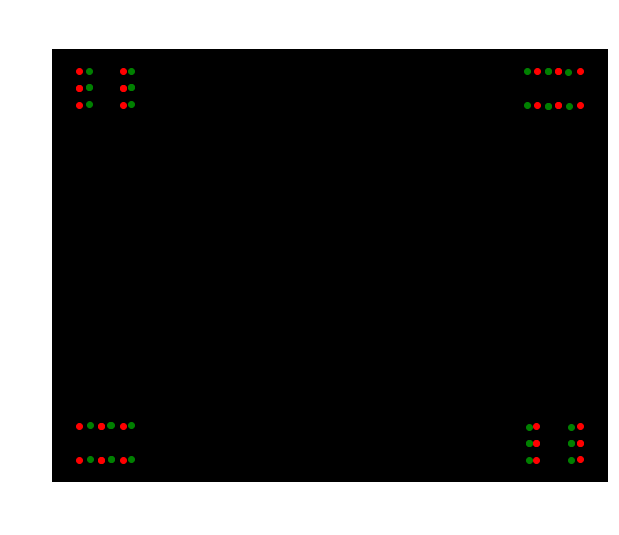

In [65]:
fig,ax = plt.subplots(1,1,figsize=(10,8))
#thes coords are center of each sensor 
raInDeg = 0 ; decInDeg = 0 ; rotSkyPos = 0 
mjds=[50000, 59000,]
for mjd,c in zip(mjds,['r','g', 'y']):
    
    print('\nUsing mjd=%d, c=%s'%(mjd,c))
    # set the MJD explicitly in camera 

    
    wavefrontSensors= radecLists[mjd]
    for detector, wavefrontSensor in wavefrontSensors.items():
        print(detector)#, wavefrontSensor)  

        corner1 = wavefrontSensor[0]
        corner2 = wavefrontSensor[1]
        corner3 = wavefrontSensor[2]
        corner4 = wavefrontSensor[3]
        ra = np.array([corner1[0], corner2[0], corner3[0], corner4[0]])
        decl = np.array([corner1[1], corner2[1], corner3[1], corner4[1]])

        # switch from (0,360) to (-180,180) 
        # just for plotting 
        m = ra>180
        ra[m] = ra[m] - 360
        #print(ra)
        #print(decl)
        ax.scatter(ra,decl,c=c, label=mjd)
    ax.set_xlabel('Ra [deg]')
    ax.set_xlabel('Decl [deg]')
    ax.grid()
#ax.legend()
ax.set_title('Difference in sensor boundaries \nbetween mjd=%d (red) and %d (green)'%(mjds[0],mjds[1]))

Do just one corner for minimal example 
    
    # all xPix are array([   0,    0, 4071, 4071])
    # and yPix are  array([   0, 1999,    0, 1999])

    # Let's take just the pixel xPx = 0, yPx = 0 (lower-left corner ... )

In [72]:
from lsst.sims.coordUtils.CameraUtils import raDecFromPixelCoords
from lsst.afw.cameraGeom.detector.detector import DetectorType
from lsst.obs.lsstSim import LsstSimMapper

camera = LsstSimMapper().camera

detectorList = []
for detector in camera:
    if (detector.getType() == DetectorType.WAVEFRONT):
        # Collect the ccd name
        detectorList.append(detector.getName())
    
radecLists = {}

for mjd in [50000,59000]:
 
    _obs = ObservationMetaData(pointingRA=0, pointingDec=0,
                                rotSkyPos=0, mjd=mjd)

    ra_dec_out = dict()
    for detector in detectorList:

        xPix = 0 ;  yPix = 0
        
        ra,dec = raDecFromPixelCoords(xPix, yPix, detector,
                                      camera=camera,
                                      obs_metadata=_obs, epoch=2000.0,
                                      includeDistortion=True)

        ra_dec_out[detector] = [(ra,dec)]
        radecLists[mjd] = ra_dec_out

In [76]:
radecLists[50000]['R:0,0 S:2,2,A'][0]

(358.82402435717046, -1.2888055413233077)

In [86]:
np.linspace(40000,75000,10)

array([40000.        , 43888.88888889, 47777.77777778, 51666.66666667,
       55555.55555556, 59444.44444444, 63333.33333333, 67222.22222222,
       71111.11111111, 75000.        ])

In [91]:
import seaborn as sns
sns.palplot(sns.color_palette("muted"))

ModuleNotFoundError: No module named 'seaborn'

In [102]:
cmap=plt.cm.get_cmap('cubehelix', 6)

Full example with just one point for just one detector :

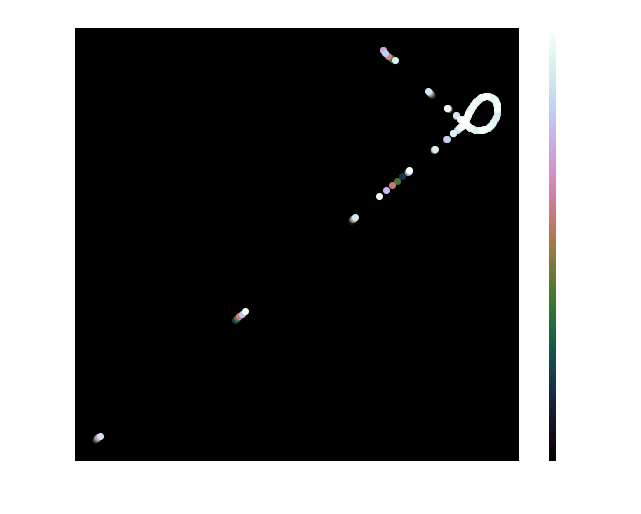

In [123]:
from lsst.sims.coordUtils.CameraUtils import raDecFromPixelCoords
from lsst.obs.lsstSim import LsstSimMapper
import matplotlib

camera = LsstSimMapper().camera

cmap = matplotlib.cm.get_cmap('cubehelix')

fig,ax = plt.subplots(1,1,figsize=(10,8))


mjds= np.linspace(50000,65000,1000)
N = len(mjds)
i = 0 
for mjd in mjds:
    _obs = ObservationMetaData(pointingRA=0, pointingDec=0,
                                rotSkyPos=0, mjd=mjd)
        
    detector = 'R:0,0 S:2,2,A'
    xPix = 0 ;  yPix = 0
    ra,dec = raDecFromPixelCoords(xPix, yPix, detector,
                                  camera=camera,
                                  obs_metadata=_obs, epoch=2000.0,
                                  includeDistortion=True)

    # switch from (0,360) to (-180,180) just for plotting 
    if ra>180:
        ra = ra - 360

    ax.scatter(ra,dec,  c=[cmap(i/N)], label=mjd)
    ax.set_xlabel('Ra [deg]')
    ax.set_ylabel('Decl [deg]')
    ax.grid()
    i += 1 

ax.set_title('Location of x,y=(0,0) for %s'%detector)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(mjds), 
                           vmax=max(mjds)))
sm._A = [] # need to set an array 
cax,kw = matplotlib.colorbar.make_axes([ax],aspect=50)
cbar = plt.colorbar(sm, cax=cax,
             label='MJD',)



`from lsst.sims.coordUtils.CameraUtils import raDecFromPixelCoords`  calls https://github.com/lsst/sims_coordUtils/blob/master/python/lsst/sims/coordUtils/CameraUtils.py , and then inside `_raDecFromPixelCoords` it does 

    xPupilList, yPupilList = pupilCoordsFromPixelCoords(xPix, yPix, chipNameList,
                                                        camera=camera, includeDistortion=includeDistortion)

    raOut, decOut = _raDecFromPupilCoords(xPupilList, yPupilList,
                                          obs_metadata=obs_metadata, epoch=epoch)
                                          
i.e. first transforms pixel coords to pupil coords ... Let's use `xPupil,yPupil=(0,0)`, and see how `_raDecFromPupilCoords` behaves - it is in https://github.com/lsst/sims_utils/blob/master/python/lsst/sims/utils/FocalPlaneUtils.py  

Lynne Jones:

"One of the steps in calculating the ra dec is incorporating atmospheric effects like refraction. Could this be the issue?" 

"You could try going from **focal plane** to **pupil coordinates** just yo make sure it’s not the distortion in the camera - if the pupil coordinates are the same, then it seems likely to be a refraction effect (or ar the very least, it’s not related to the camera itself)."

ra

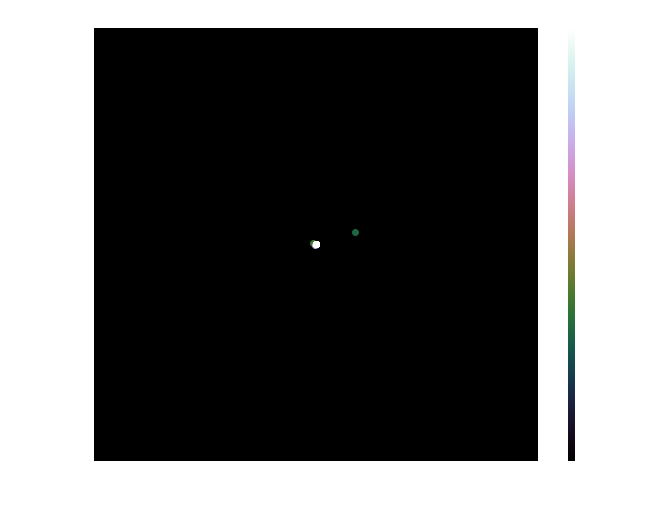

In [225]:
from lsst.sims.utils import _raDecFromPupilCoords
import matplotlib

cmap = matplotlib.cm.get_cmap('cubehelix')

fig,ax = plt.subplots(1,1,figsize=(10,8))


mjds= np.linspace(50000,65000,100)
N = len(mjds)
i = 0 
ra_list=[]
dec_list=[]
for mjd in mjds:
    _obs = ObservationMetaData(pointingRA=0, pointingDec=0,
                                rotSkyPos=0, mjd=mjd)
        
    xPix = 0 ;  yPix = 0
    ra_rad,dec_rad = _raDecFromPupilCoords(xPix, yPix,obs_metadata=_obs, epoch=2000.0,)
    ra = np.rad2deg(ra_rad)
    dec = np.rad2deg(dec_rad)
    ra_list.append(ra)
    dec_list.append(dec)
    # switch from (0,360) to (-180,180) just for plotting 
    if ra>180:
        ra = ra - 360

    ax.scatter(ra,dec,  c=[cmap(i/N)], label=mjd)
    ax.set_xlabel('Ra [deg]')
    ax.set_ylabel('Decl [deg]')
    ax.grid()
    i += 1 

ax.set_title('Location of x,y=(0,0) for %s'%detector)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(mjds), 
                           vmax=max(mjds)))
sm._A = [] # need to set an array 
cax,kw = matplotlib.colorbar.make_axes([ax],aspect=50)
cbar = plt.colorbar(sm, cax=cax,
             label='MJD',)



(-0.001, 0.001)

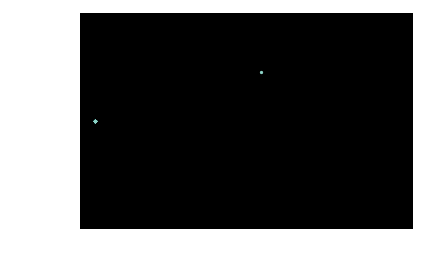

In [238]:
plt.scatter(ra_list,dec_list,s=5)
plt.xlim(-1e-4,0.002)
plt.ylim(-0.001,0.001)

In [227]:
dec_list

[-2.4456071603200833e-14,
 -7.139768440636097e-12,
 -2.656091995665398e-14,
 -2.3298491295844318e-14,
 -3.552115995572706e-15,
 4.856728011424673e-15,
 -8.406681479037676e-16,
 -3.760889057700016e-15,
 -1.2612959746051819e-14,
 8.846172730289348e-13,
 -3.791574558926086e-15,
 -7.002836168647592e-16,
 -3.2944784273026492e-15,
 -3.791807197359563e-15,
 9.522447211753158e-15,
 1.9831897859573114e-14,
 1.6076391956235523e-14,
 2.5738210047995752e-14,
 5.424267876531774e-16,
 9.288206125064943e-15,
 1.696695627715121e-14,
 -3.7660860675834646e-15,
 3.9549291503232226e-14,
 7.580909096445276e-12,
 5.40279290833984e-14,
 1.9776756354536484e-14,
 -5.689751629481781e-16,
 1.0159375725076023e-14,
 2.6380826281458815e-14,
 7.61121274320931e-14,
 0.0004486873050321381,
 8.727942248692722e-14,
 4.486120829103088e-14,
 8.782964348100878e-15,
 1.800396678079799e-14,
 3.184964310821548e-14,
 8.725576380003853e-14,
 3.945763475312226e-05,
 1.1592646434223303e-13,
 6.416379940409355e-14,
 1.149784754981

Test if precession is responsible or something else ... Use astropy https://docs.astropy.org/en/stable/api/astropy.coordinates.PrecessedGeocentric.html : 

In [125]:
from astropy.coordinates import SkyCoord
hcg7_center = SkyCoord.from_name('HCG 7')

In [128]:
from astropy import units as u
from urllib.request import urlretrieve
from urllib.parse import urlencode
impix = 1024
imsize = 12*u.arcmin
cutoutbaseurl = 'http://skyservice.pha.jhu.edu/DR12/ImgCutout/getjpeg.aspx'
query_string = urlencode(dict(ra=hcg7_center.ra.deg, 
                                     dec=hcg7_center.dec.deg, 
                                     width=impix, height=impix, 
                                     scale=imsize.to(u.arcsec).value/impix))
url = cutoutbaseurl + '?' + query_string

# this downloads the image to your disk
urlretrieve(url, 'HCG7_SDSS_cutout.jpg')

('HCG7_SDSS_cutout.jpg', <http.client.HTTPMessage at 0x7f42726b2fd0>)

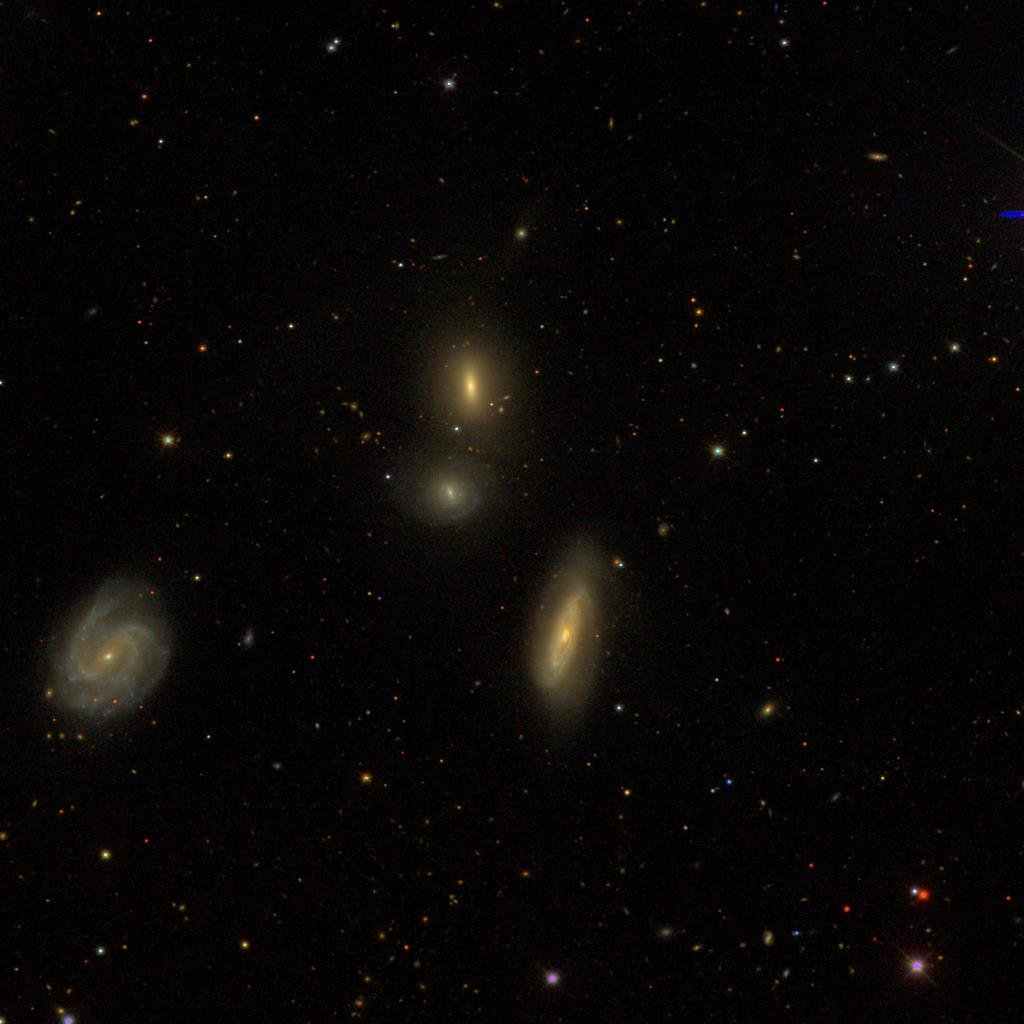

In [130]:
import IPython.display
IPython.display.Image('HCG7_SDSS_cutout.jpg')

In [158]:
from astropy.coordinates import PrecessedGeocentric
from astropy.time import Time
from astropy import units as u
t1 = Time(51000, format='mjd')
t2 = Time(61000, format='mjd')
coord = PrecessedGeocentric(ra=0*u.deg, dec=0.*u.deg, obstime=t1, equinox=t2)

In [159]:
coord

<PrecessedGeocentric Coordinate (equinox=61000.0, obstime=51000.0, obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s): (ra, dec) in deg
    (0., 0.)>

In [189]:
a = Time('J2000')
a.mjd

51544.5

In [180]:
from astropy.coordinates import SkyCoord
#from astropy.coordinates import ICRS

c1_gcrs = SkyCoord(ra=0*u.degree, dec=0*u.degree, frame='gcrs',equinox='J2000')


c2_gcrs = c_icrs.transform_to(PrecessedGeocentric(equinox='J1975', )) 

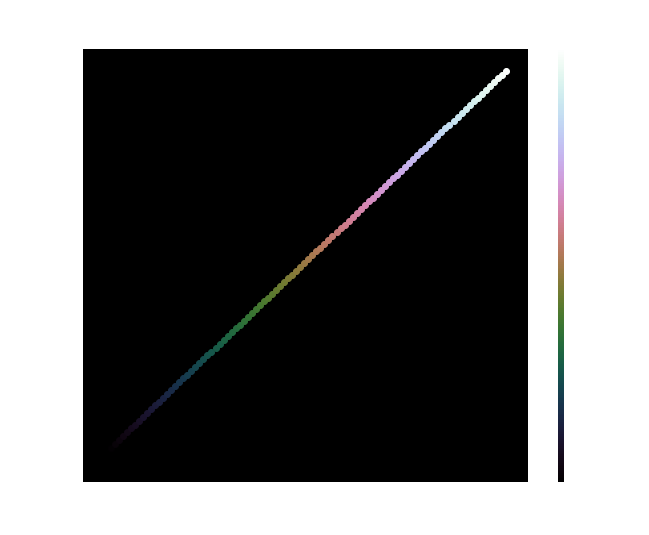

In [207]:
import matplotlib
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import PrecessedGeocentric

cmap = matplotlib.cm.get_cmap('cubehelix')

fig,ax = plt.subplots(1,1,figsize=(10,8))


mjds= np.linspace(50000,65000,100)
N = len(mjds)
i = 0 

c1_gcrs = SkyCoord(ra=0*u.degree, dec=0*u.degree, frame='gcrs',equinox='J2000')
    
for mjd in mjds:
    t2 = Time(mjd, format='mjd')
    c2_gcrs = c1_gcrs.transform_to(PrecessedGeocentric(equinox=t2) ) 
    ra,dec = c2_gcrs.ra.deg, c2_gcrs.dec.deg

    # switch from (0,360) to (-180,180) just for plotting 
    if ra>180:
        ra = ra - 360

    ax.scatter(ra,dec,  c=[cmap(i/N)], label=mjd)
    ax.set_xlabel('Ra [deg]')
    ax.set_ylabel('Decl [deg]')
    ax.grid()
    i += 1 

ax.set_title('Transformation of ra,dec=(0,0) from epoch J2000 (mjd=51544.5) \nto an epoch given by the mjd')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(mjds), 
                           vmax=max(mjds)))
sm._A = [] # need to set an array 
cax,kw = matplotlib.colorbar.make_axes([ax],aspect=50)
cbar = plt.colorbar(sm, cax=cax,
             label='MJD',)

